# Remove Stripes from fMOST Brain

In their registration pipeline for the fMOST brain, Qu et al. identified the sinusoidal noise as multiplicative, and used log transform and notch filtering to solve the issue. Here is the reimplementation of this method in Python.

In [1]:
import numpy as np
from scipy import ndimage
import cv2
import os
from tifffile import imread, imwrite
import matplotlib.pyplot as plt
import math

## The problem
The sinusoidal stripe can have influence on band removal and the following analysis

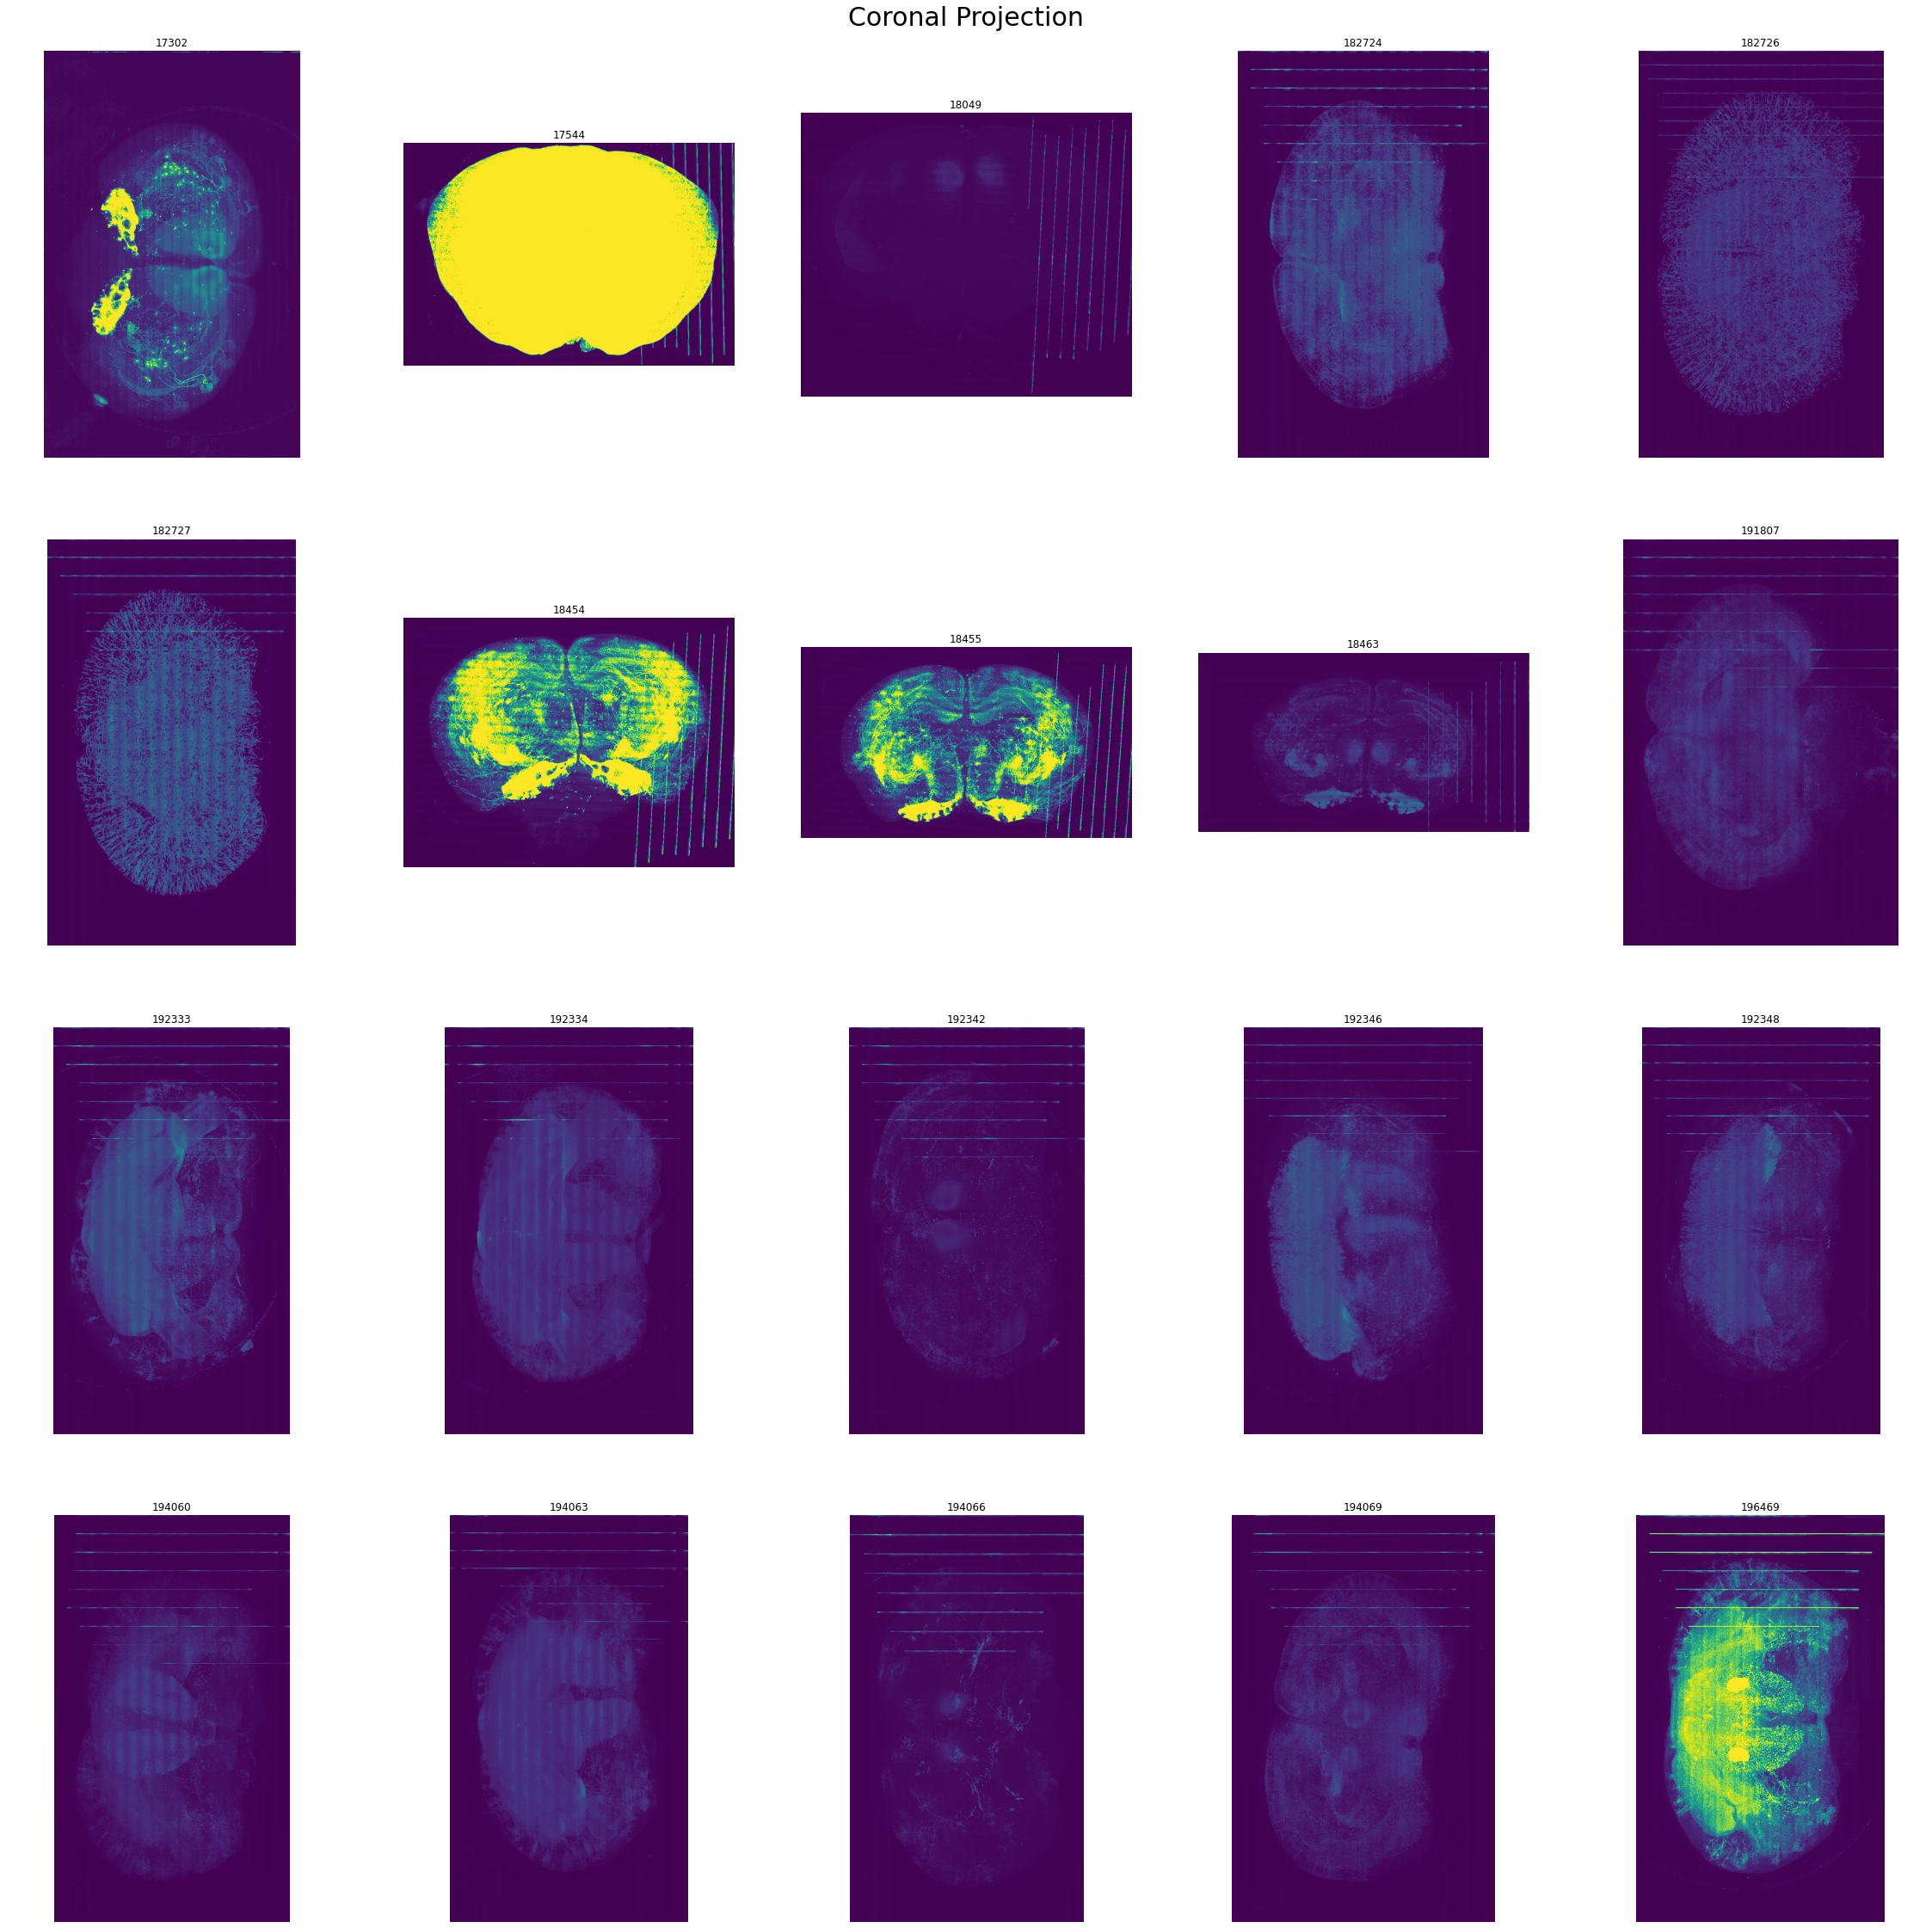

In [2]:
in_dir = '../results/lowestRes'

cols = 5
rows = math.ceil(len(os.listdir(in_dir)) / cols)
fig = plt.figure(figsize=(40, 40))
plt.axis('off')
plt.title('Coronal Projection', {'fontsize': 30}, pad=30)

for i, brain in enumerate(os.listdir(in_dir)):
    img = imread(os.path.join(in_dir, brain))
    cor = cv2.convertScaleAbs(img.max(axis=0), alpha=255.0 / img.max())
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(cor)
    plt.axis('off')
    plt.title(brain.strip('.tif'))

## Algorithm

In [2]:
def filter_stripe(img, angle=0, cutoff=10, radius=30, sigma=5):
    # making the filter function H
    hsize = max(img.shape[1], img.shape[2]) * 2 + 1
    H = np.ones([hsize, hsize])
    ct = round(hsize / 2)
    fro, to = max(0, ct-radius), min(ct+radius+1, hsize)
    H[fro:to,:] = 0
    fro, to = max(0, ct-cutoff), min(ct+cutoff+1, hsize)
    H[:,fro:to] = 1
    H = ndimage.rotate(H, angle, reshape=False)
    H = cv2.GaussianBlur(H, (sigma*6+1,)*2, sigma)
    H = H - H.min()
    H = H / H.max()
    hf = img.shape[1]//2, img.shape[2]//2
    H = H[ ct-hf[0] : ct-hf[0]+img.shape[1], ct-hf[1] : ct-hf[1]+img.shape[2] ]
    # filtering
    out = []
    for sl in img:
        sl = np.log(sl + 1.0)
        sl = np.fft.fft2(sl)
        sl = np.fft.fftshift(sl)
        sl = H * sl
        # return np.float_power(abs(sl.real)+0.01, 0.3)
        sl = np.fft.ifftshift(sl)
        sl = np.fft.ifft2(sl)
        sl = np.exp(sl.real) - 1
        out.append(sl)
    return np.stack(out).astype(img.dtype)

## Trial

In [3]:
# directories
in_dir = '../results/lowestRes'
out_dir = '../results/preprocess/notch/stripeRemoved'
proj_dir = '../results/preprocess/notch/removedProjection'

os.makedirs(out_dir, exist_ok=True)
os.makedirs(proj_dir, exist_ok=True)

old = ['17544', '18049', '18454', '18455', '18463']

for i, brain in enumerate(os.listdir(in_dir)):
    img = imread(os.path.join(in_dir, brain))
    if brain.strip('.tif') in old:
        angle = 90
    else:
        angle = 0
    out = filter_stripe(img, angle)
    imwrite(os.path.join(out_dir, brain), out)
    imwrite(os.path.join(proj_dir, brain), cv2.convertScaleAbs(out.max(axis=0), alpha=255.0 / out.max()))
    print(brain, 'done.')

17302.tif done.
17544.tif done.
18049.tif done.
182724.tif done.
182726.tif done.
182727.tif done.
18454.tif done.
18455.tif done.
18463.tif done.
191807.tif done.
192333.tif done.
192334.tif done.
192342.tif done.
192346.tif done.
192348.tif done.
194060.tif done.
194063.tif done.
194066.tif done.
194069.tif done.
196469.tif done.


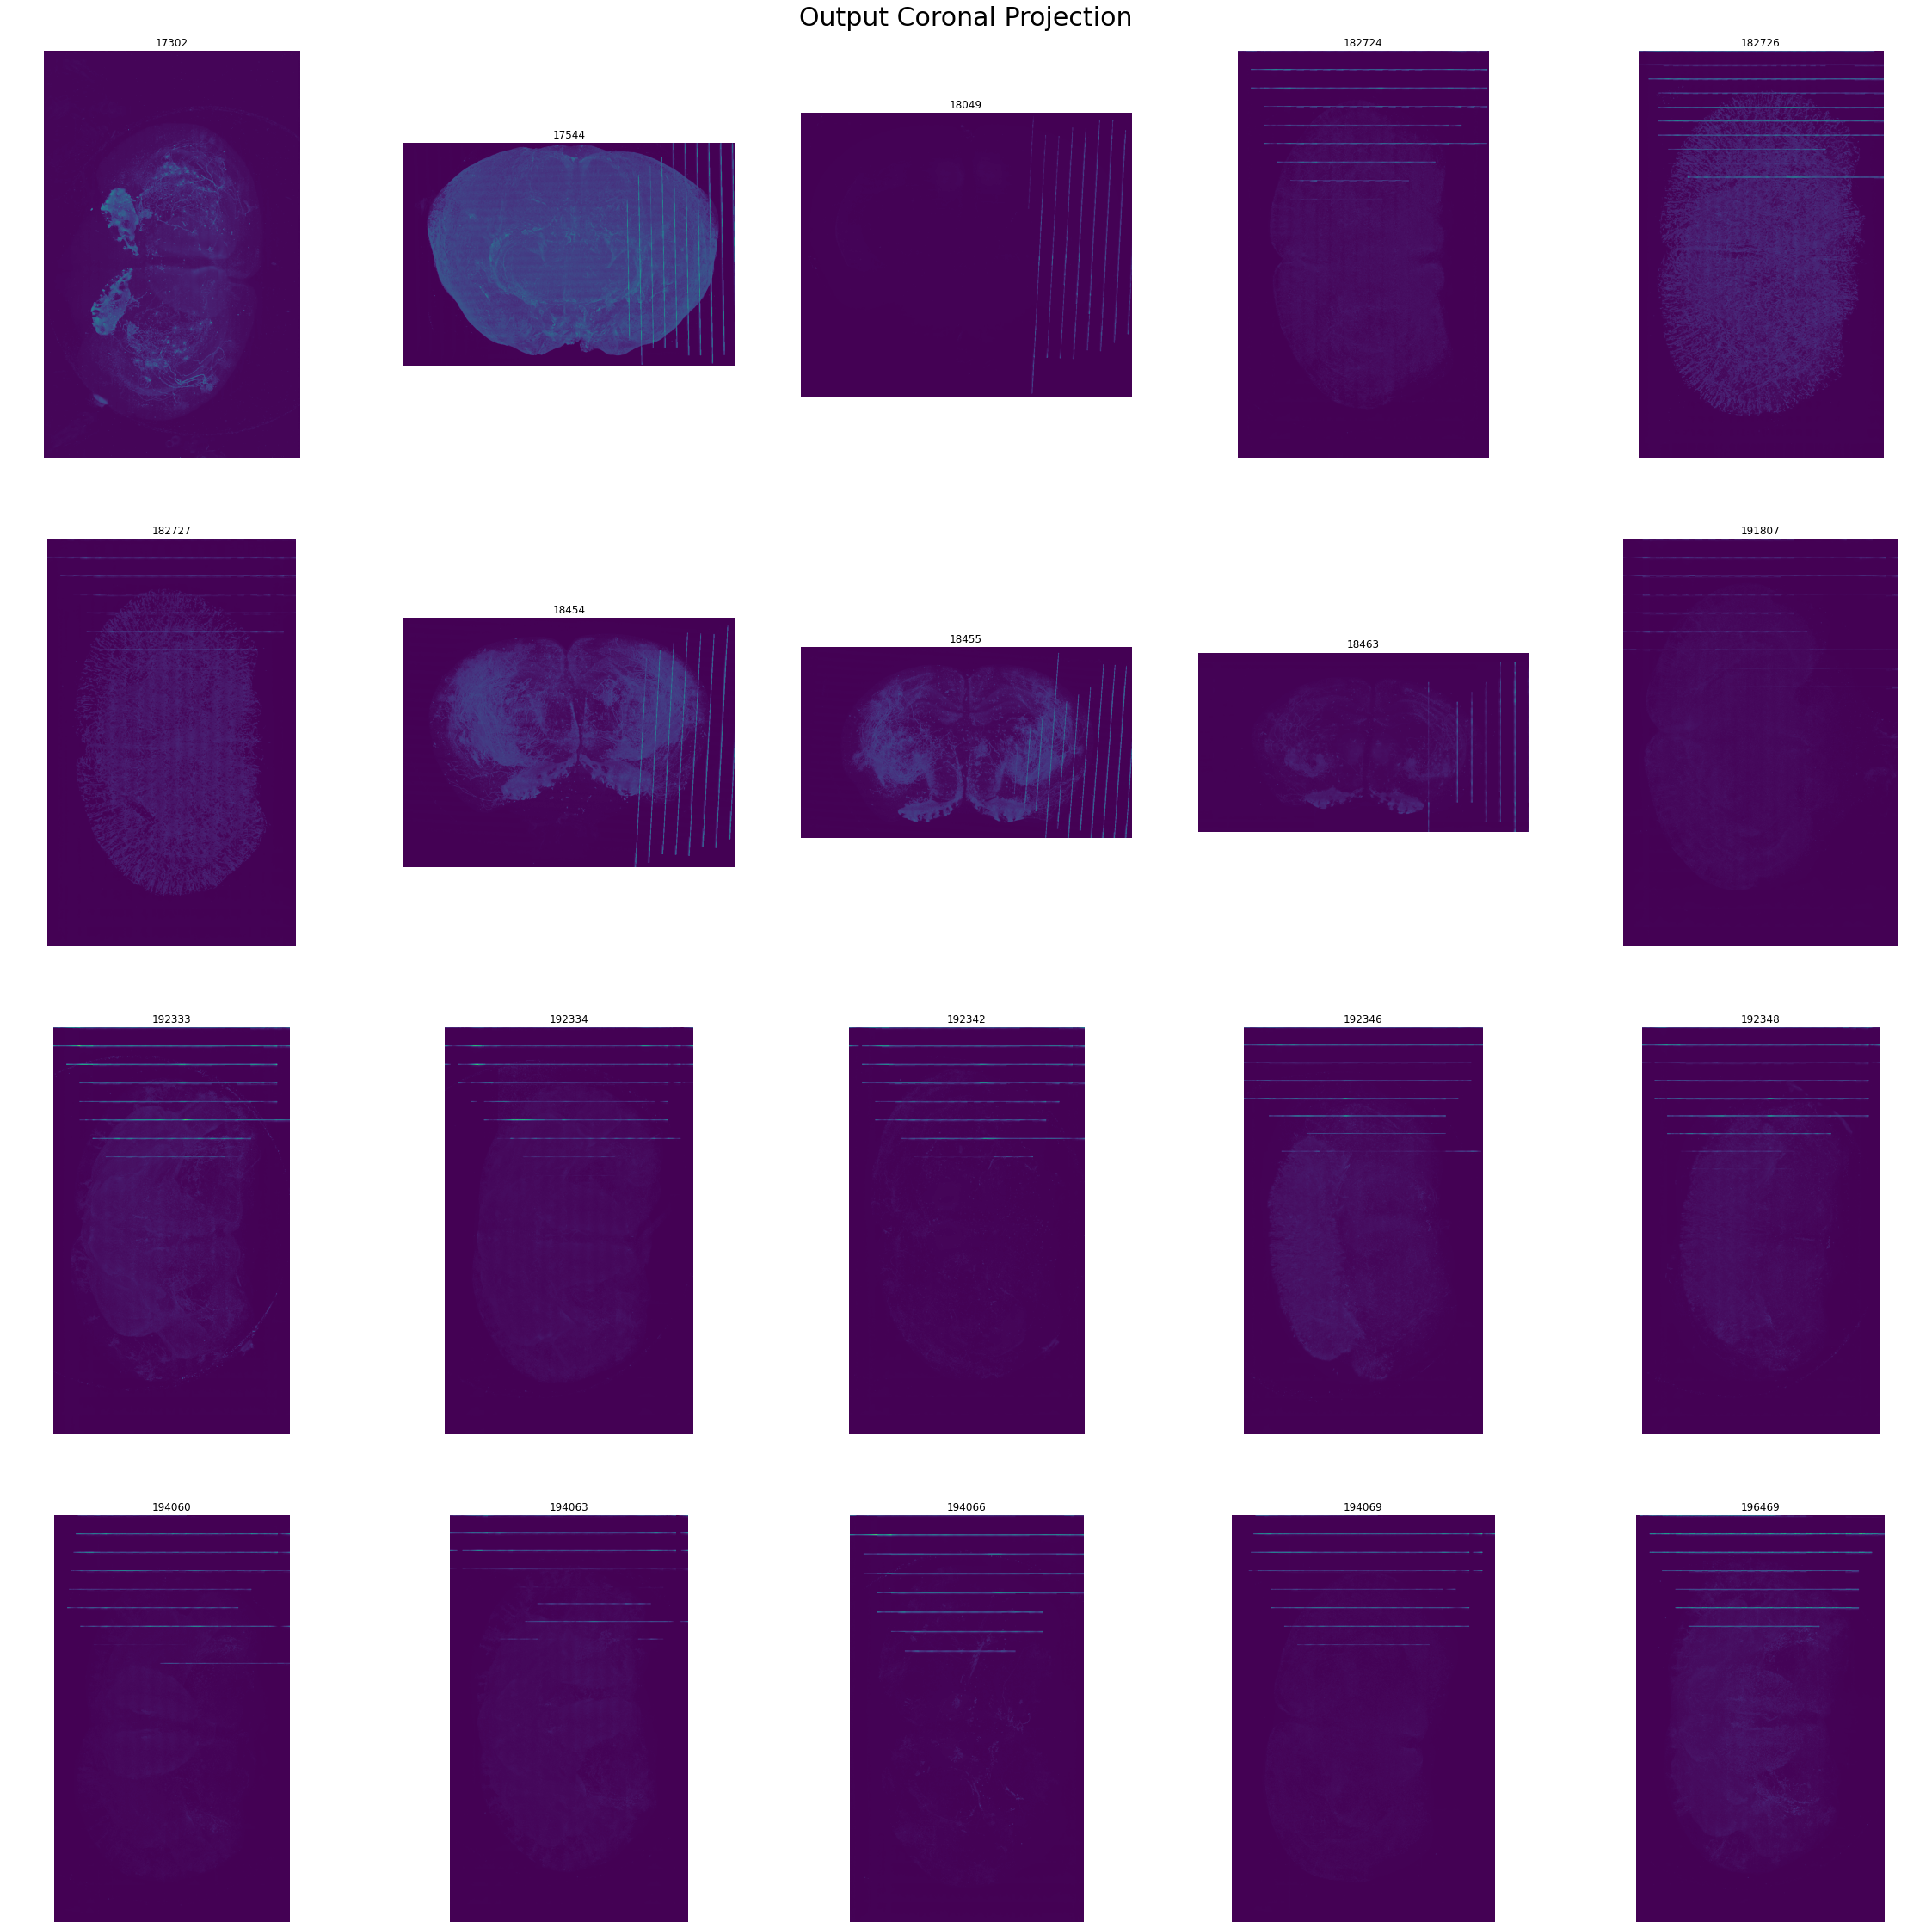

In [16]:
cols = 5
rows = math.ceil(len(os.listdir(in_dir)) / cols)
fig = plt.figure(figsize=(40, 40))
plt.axis('off')
plt.title('Output Coronal Projection', {'fontsize': 30}, pad=30)

for i, brain in enumerate(os.listdir(proj_dir)):
    img = imread(os.path.join(proj_dir, brain))
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(brain.strip('.tif'))